In [1]:
import os
import numpy as np
import pandas as pd

from tqdm.auto import tqdm
tqdm.pandas()

import cv2

import matplotlib.pyplot as plt
import seaborn as sns

from function_beta import *

from sklearn.preprocessing import StandardScaler

import pickle


In [2]:
#constant and path

STATE = 33443

# путь к фото
path_img = './imgs'

# путь к моделям
path_models = './models'


## Загрузка данных

In [3]:
list_img = os.listdir(path_img)

In [4]:
len(list_img)

10

In [5]:
#создание датафрейма
data_csv = pd.DataFrame(list_img, columns=['crop_img_name'])
data_csv['path_img'] = path_img
data_csv.head(2)

crop_img_name path_img
0  0bd8b2e1-2306105_2024_06_22_03_34_11_64_00_16.png   ./imgs
1  11a0eda4-2306105_2024_06_23_15_05_32_46_00_16.png   ./imgs

## Подготовка данных

In [6]:
def add_0_futures(row):
    path = os.path.join(row['path_img'], row['crop_img_name'])
    img = cv2.imread(path)

    return pd.Series([img.shape[1], img.shape[0]])

In [7]:
# добавление первых признаков, ширина, высота
col_0_futures = ['width', 'height']

data_csv[col_0_futures] = data_csv.progress_apply(add_0_futures, axis=1)

  0%|          | 0/10 [00:00<?, ?it/s]

In [8]:
# общая функция для добавления в датасет нескольких признаков

def add_futures(row):
    path = os.path.join(row['path_img'], row['crop_img_name'])
    img = cv2.imread(path)
    img = cv2.resize(img, (128, 128), interpolation = cv2.INTER_LINEAR)
    img = crop_img(img)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    teng_scr = TENG(img)
    blur_scr = blur_score(img)
    gray_scr = gray_score(img_gray)
    
    #текстурные признаки
    glcm = my_glcm_numpy(img_gray, distance=50).reshape(256,256,1,1)
    
    contrast_2_scr = contrast_2_score(glcm)
    dissimilarity_scr = dissimilarity_score(glcm)
    homogeneity_scr = homogeneity_score(glcm)
    energy_scr = energy_score(glcm)

    count_std_scr, max_value_scr, count_more_120_scr = get_std_square(img_gray)

    #шумовые признаки
    mean_noise_scr, std_noise_scr = calculate_noise_metrics(img_gray)
    percent_noise_scr = is_valid(img)

    #--хроматические признаки--
    white_balance_scr = calculate_white_balance(img)

    #признаки на основе fft
    hf_mean_scr = fft_features(img_gray)

    monochrome_scr = flag_monochrome(img, threshold=10)
    
    return pd.Series([teng_scr, 
                      blur_scr, 
                      gray_scr, 
                      
                      contrast_2_scr,
                      dissimilarity_scr,
                      homogeneity_scr,
                      energy_scr, 
                      
                      count_std_scr, 
                      count_more_120_scr, 
                      
                      mean_noise_scr, 
                      percent_noise_scr, 
                      
                      #colorfulness_csr,
                      #saturation_scr,
                      white_balance_scr,

                      hf_mean_scr,

                    #HK["mean_L"],
                    #HK["std_L"],
                    #HK["mean_C"],
                    #HK["std_C"],
                    #HK["mean_h"],
                    #HK["std_h"],
                    #HK["mean_L_HK"],
                    #HK["std_L_HK"],
                    #HK["mean_B_HK"],
                    #HK["std_B_HK"],
                      
                      monochrome_scr,
                      
                      #b_mean, g_mean, r_mean,                      

                     ])

In [9]:
# проверка работы
row = data_csv.iloc[2]
add_futures(row)

0     14774.252064
1      1988.126775
2         0.299903
3      4048.545222
4        50.042753
5         0.030372
6         0.032412
7        98.000000
8        46.000000
9       109.377008
10        0.852101
11       61.720685
12      132.310089
13        0.000000
dtype: float64

In [10]:
cols_futures = ['teng_scr', 
                'blur_scr', 
                'gray_scr', 
                
                'contrast_2_scr',
                'dissimilarity_scr',
                'homogeneity_scr',
                'energy_scr',
                
                'count_std_scr',
                #'max_value_scr',
                'count_more_120_scr',
                
                'mean_noise_scr',
                #'std_noise_scr',
                'percent_noise_scr',

                #'colorfulness_csr',
                #'saturation_scr',
                'white_balance_scr',
                
                'hf_mean_scr',

                #"mean_L",
                #"std_L",
                #"mean_C",
                #"std_C",
                #"mean_h",
                #"std_h",
                #"mean_L_HK",
                #"std_L_HK",
                #"mean_B_HK",
                #"std_B_HK",

                'monochrome_scr',

                #'b_mean', 'g_mean', 'r_mean',
                
               ]

In [11]:
# добавление нескольких признаков
data_csv[cols_futures] = data_csv.progress_apply(add_futures, axis=1)

  0%|          | 0/10 [00:00<?, ?it/s]

In [12]:
data_csv.head(2)

crop_img_name path_img  width  height  \
0  0bd8b2e1-2306105_2024_06_22_03_34_11_64_00_16.png   ./imgs    209     136   
1  11a0eda4-2306105_2024_06_23_15_05_32_46_00_16.png   ./imgs    236     149   

      teng_scr    blur_scr  gray_scr  contrast_2_scr  dissimilarity_scr  \
0  6248.521005  443.502037  0.260351      239.837336          12.261795   
1  6398.174213  380.945155  0.273736     1533.684892          27.996934   

   homogeneity_scr  energy_scr  count_std_scr  count_more_120_scr  \
0         0.077508    0.031558            7.0                 0.0   
1         0.058003    0.022628           60.0                28.0   

   mean_noise_scr  percent_noise_scr  white_balance_scr  hf_mean_scr  \
0      111.254968           0.999365          20.677178   114.033737   
1      113.021777           0.997550          35.445426   113.888725   

   monochrome_scr  
0             0.0  
1             0.0

In [13]:
# столбцы для модели
test_col = ['width'] + cols_futures
test_col

['width',
 'teng_scr',
 'blur_scr',
 'gray_scr',
 'contrast_2_scr',
 'dissimilarity_scr',
 'homogeneity_scr',
 'energy_scr',
 'count_std_scr',
 'count_more_120_scr',
 'mean_noise_scr',
 'percent_noise_scr',
 'white_balance_scr',
 'hf_mean_scr',
 'monochrome_scr']

In [14]:
data_test = data_csv[test_col]
#data_test.columns = test_col

In [15]:
data_test.head(1)

width     teng_scr    blur_scr  gray_scr  contrast_2_scr  \
0    209  6248.521005  443.502037  0.260351      239.837336   

   dissimilarity_scr  homogeneity_scr  energy_scr  count_std_scr  \
0          12.261795         0.077508    0.031558            7.0   

   count_more_120_scr  mean_noise_scr  percent_noise_scr  white_balance_scr  \
0                 0.0      111.254968           0.999365          20.677178   

   hf_mean_scr  monochrome_scr  
0   114.033737             0.0

In [16]:
x_test = data_test

## Модели

### масштабирование данных

In [17]:
path_scaler = os.path.join(path_models, 'scaler_04_04_2025_beta_v003c.pkl')

with open(path_scaler, 'rb') as f:
    scaler = pickle.load(f)

x_test_scaler = scaler.transform(x_test)

In [18]:
x_test_scaler.min(), x_test_scaler.max()

(np.float64(0.0), np.float64(1.3010383099568272))

### LogisticRegression

In [19]:
path_model = os.path.join(path_models, 'lr_model_04_04_2025_beta_v003c.pkl')

with open(path_model, 'rb') as f:
    lr = pickle.load(f)
lr

LogisticRegression(C=10.0, solver='liblinear')

In [20]:
probabilities_valid = lr.predict_proba(x_test_scaler)
probabilities_one_valid = probabilities_valid[:, 1]

In [21]:
#добавление в таблицу предсказаний от LR
data_csv['proba_lr'] = probabilities_one_valid

In [22]:
## Нанесение на фото уверенности модели в качестве изображения

# font
font = cv2.FONT_HERSHEY_SIMPLEX
# org
org = (15, 20)
# fontScale
fontScale = 0.5
# Blue color in BGR
color = (0, 255, 0)
# Line thickness of 2 px
thickness = 1
# Using cv2.putText() method
text = 'text'

def put_text(img, proba):
    text_viol_belt = str(np.round(proba, 3))
    img = cv2.putText(img, text_viol_belt, org, font, 
                   fontScale, color, thickness, cv2.LINE_AA)
    return img


  0%|          | 0/10 [00:00<?, ?it/s]

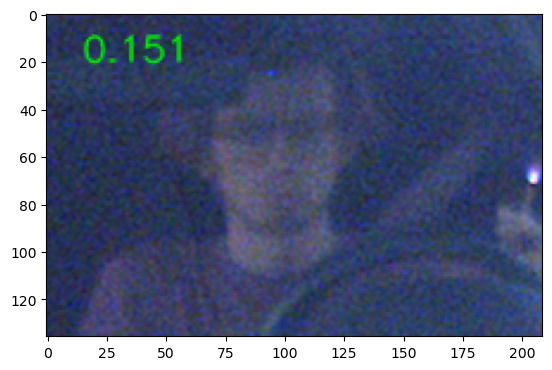

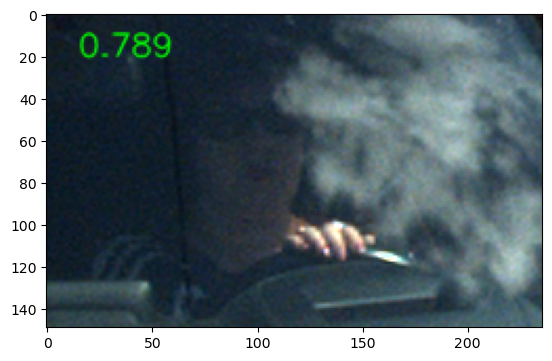

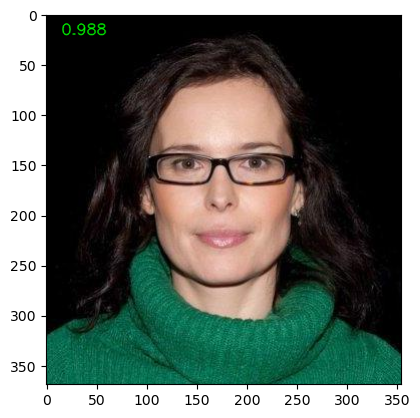

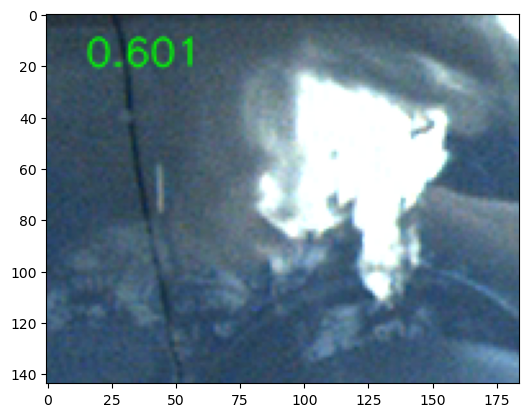

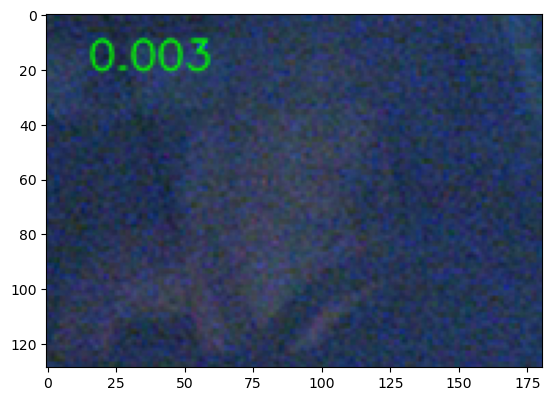

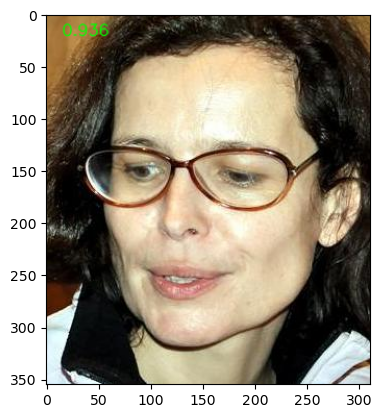

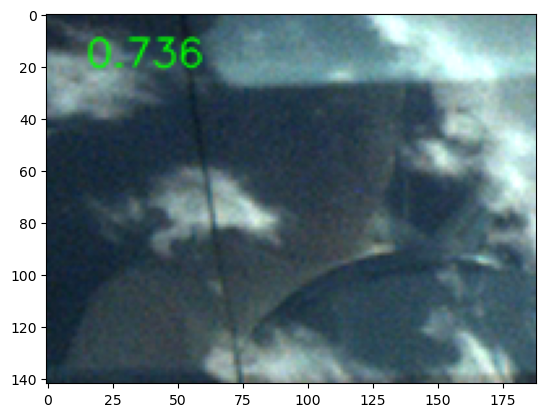

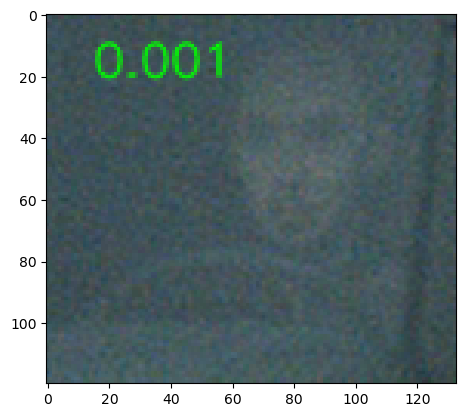

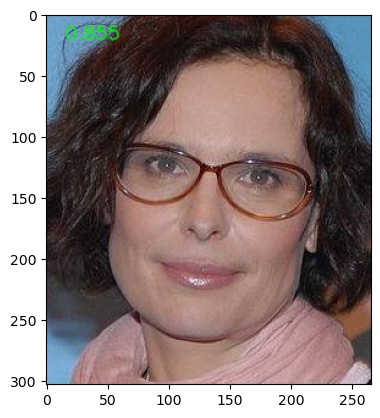

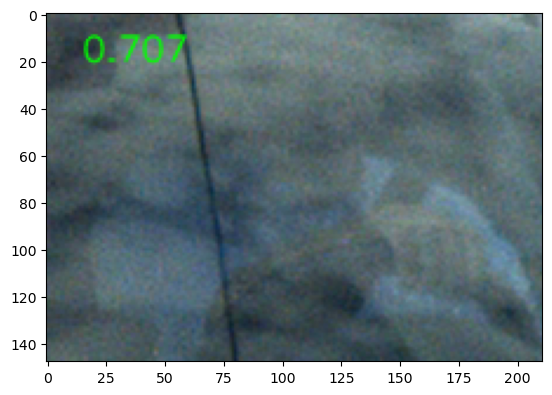

In [23]:
# показ фото с уверенностью модели в качестве изображения
for i in tqdm(range(len(data_csv))):
    crop_img_name = data_csv.iloc[i]['crop_img_name']
    path_img = data_csv.iloc[i]['path_img']
    model_confidence = data_csv.iloc[i]['proba_lr']
    
    path_read = os.path.join(path_img, crop_img_name)
    img = cv2.imread(path_read)

    #нанесение текста с уверенностью модели
    img = put_text(img, model_confidence)
    
    img_plt = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_plt)
    plt.show()


### svm

In [24]:
path_model = os.path.join(path_models, 'svm_model_04_04_2025_beta_v003c.pkl')

with open(path_model, 'rb') as f:
    svm_model = pickle.load(f)
svm_model

SVC(C=77.5427145297961, gamma=0.24221828027687053, probability=True,
    random_state=33443)

In [25]:
probabilities_valid = svm_model.predict_proba(x_test_scaler)
probabilities_one_valid = probabilities_valid[:, 1]


In [26]:
#добавление в таблицу предсказаний от SVM
data_csv['proba_svm'] = probabilities_one_valid
data_csv.head(2)

crop_img_name path_img  width  height  \
0  0bd8b2e1-2306105_2024_06_22_03_34_11_64_00_16.png   ./imgs    209     136   
1  11a0eda4-2306105_2024_06_23_15_05_32_46_00_16.png   ./imgs    236     149   

      teng_scr    blur_scr  gray_scr  contrast_2_scr  dissimilarity_scr  \
0  6248.521005  443.502037  0.260351      239.837336          12.261795   
1  6398.174213  380.945155  0.273736     1533.684892          27.996934   

   homogeneity_scr  energy_scr  count_std_scr  count_more_120_scr  \
0         0.077508    0.031558            7.0                 0.0   
1         0.058003    0.022628           60.0                28.0   

   mean_noise_scr  percent_noise_scr  white_balance_scr  hf_mean_scr  \
0      111.254968           0.999365          20.677178   114.033737   
1      113.021777           0.997550          35.445426   113.888725   

   monochrome_scr  proba_lr  proba_svm  
0             0.0   0.15053   0.091445  
1             0.0   0.78911   0.725967

  0%|          | 0/10 [00:00<?, ?it/s]

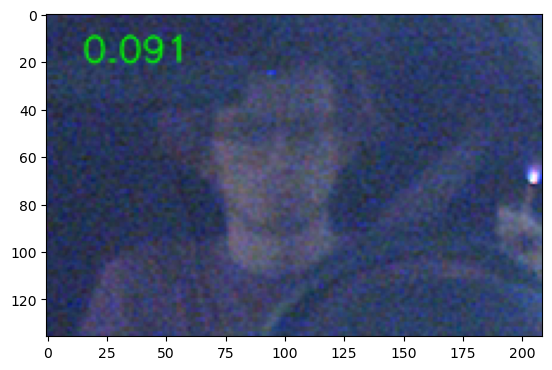

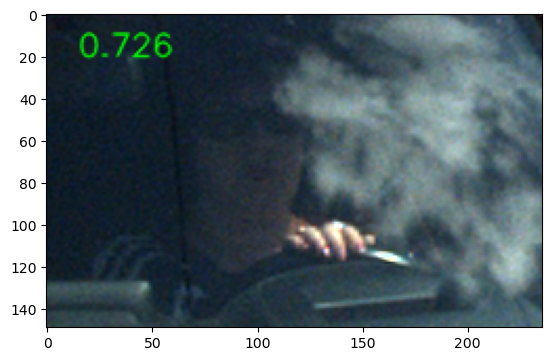

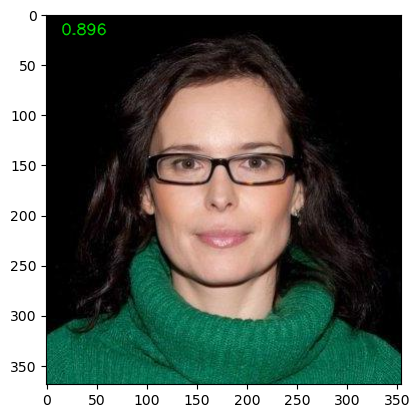

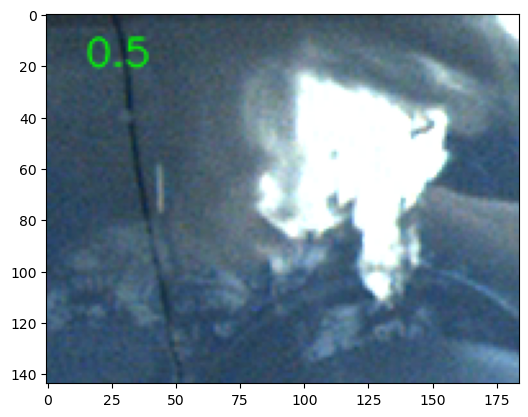

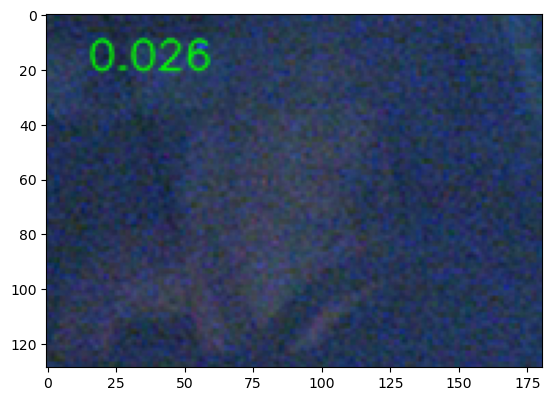

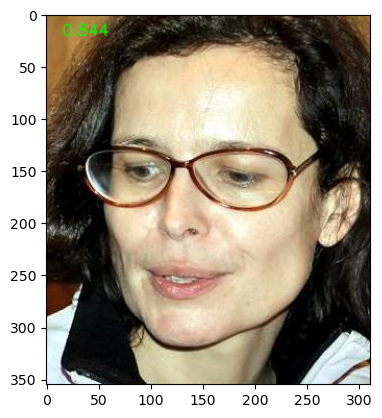

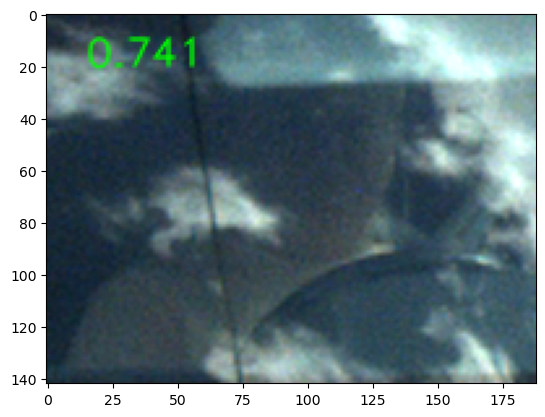

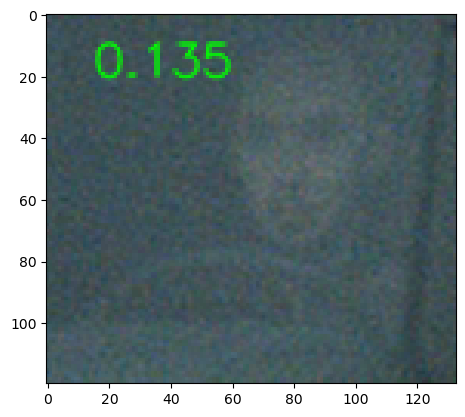

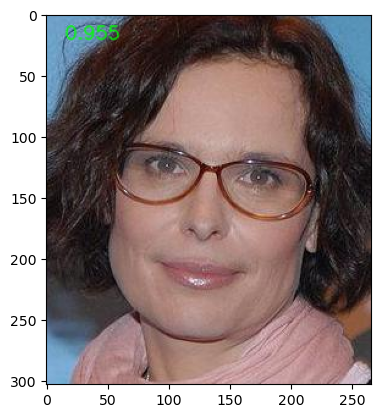

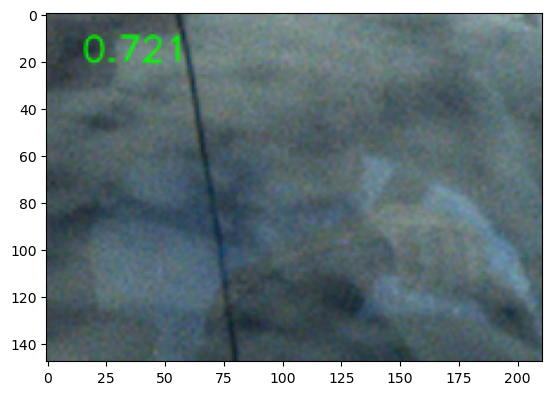

In [27]:
# показ фото с уверенностью модели в качестве изображения

for i in tqdm(range(len(data_csv))):
    crop_img_name = data_csv.iloc[i]['crop_img_name']
    path_img = data_csv.iloc[i]['path_img']
    model_confidence = data_csv.iloc[i]['proba_svm']
    
    path_read = os.path.join(path_img, crop_img_name)
    img = cv2.imread(path_read)

    #нанесение текста с уверенностью модели
    img = put_text(img, model_confidence)
    img_plt = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_plt)
    plt.show()

    #full_path = f"cp {path_read} {path_save}"
    #print(full_path)
    #os.system(full_path)